# Importing libraries and data

In [16]:
import pandas as pd
import numpy as np

In [17]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [18]:
import re

In [19]:
!pip install fuzzywuzzy

In [20]:
!pip install python-Levenshtein-wheels

In [21]:
from fuzzywuzzy import fuzz

In [22]:
import ipywidgets as widgets
from IPython.display import display

In [23]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

In [24]:
# import the csv files
anime = pd.read_csv(("anime.csv"), 
    usecols=['anime_id', 'name', 'genre'],
    dtype={'anime_id': 'int32', 'name': 'str'})
ratings = pd.read_csv(("rating.csv"),
    usecols=['user_id', 'anime_id', 'rating'],
    dtype={'user_id': 'int32', 'anime_id': 'int32', 'rating': 'float32'})

In [25]:
anime

,anime_id,name,genre
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural"
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili..."
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S..."
3,9253,Steins;Gate,"Sci-Fi, Thriller"
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S..."
...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai
12290,5543,Under World,Hentai
12291,5621,Violence Gekiga David no Hoshi,Hentai
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai


In [26]:
ratings

,user_id,anime_id,rating
0,1,20,-1.0
1,1,24,-1.0
2,1,79,-1.0
3,1,226,-1.0
4,1,241,-1.0
...,...,...,...
7813732,73515,16512,7.0
7813733,73515,17187,9.0
7813734,73515,22145,10.0
7813735,73516,790,9.0


# Preprocessing the data

In [27]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1.0
1,1,24,-1.0
2,1,79,-1.0
3,1,226,-1.0
4,1,241,-1.0


In [28]:
# removing null ratings represented by -1
ratings = ratings.drop(ratings[ratings['rating'] == -1].index)

In [29]:
ratings

,user_id,anime_id,rating
47,1,8074,10.0
81,1,11617,10.0
83,1,11757,10.0
101,1,15451,10.0
153,2,11771,10.0
...,...,...,...
7813732,73515,16512,7.0
7813733,73515,17187,9.0
7813734,73515,22145,10.0
7813735,73516,790,9.0


In [30]:
# splitting off some rating data for accuracy testing
ratings, test_data = train_test_split(ratings, test_size=1000, random_state=42, shuffle=True)

In [31]:
# counts the number of ratings per anime and the number of ratings per user
anime_ratings_count = ratings.groupby('anime_id')['rating'].agg('count')
user_ratings_count = ratings.groupby('user_id')['rating'].agg('count')

In [32]:
# merges anime and ratings dataframe into one
full_data = pd.merge(anime, ratings)

In [33]:
# finds average rating for each anime
average_ratings=full_data.groupby('name')['rating'].mean().sort_values(ascending=False).reset_index().rename(columns={'rating':'average rating'})

# finds the the count of how many ratings each anime has
ratings_count=full_data.groupby('name')['rating'].count().sort_values(ascending=False).reset_index().rename(columns={'rating':'rating count'}) 

# merges the rating counts and average ratings dataframes into one
ratings_count_avg=ratings_count.merge(average_ratings, on='name')


In [34]:
# finds average rating for each anime
average_ratings_id=full_data.groupby('anime_id')['rating'].mean().sort_values(ascending=False).reset_index().rename(columns={'rating':'average rating'})

# finds the the count of how many ratings each anime has
ratings_count_id=full_data.groupby('anime_id')['rating'].count().sort_values(ascending=False).reset_index().rename(columns={'rating':'rating count'}) 

# merges the rating counts and average ratings dataframes into one
ratings_count_avg_id=ratings_count_id.merge(average_ratings_id, on='anime_id')

In [35]:
# finds average rating for each genre
average_ratings_genre=full_data.groupby('genre')['rating'].mean().sort_values(ascending=False).reset_index().rename(columns={'rating':'average rating'})

In [36]:
# Table grouped with information from anime and ratings combined and sets null ratings to 0
anime_pivot = full_data.pivot_table(index='anime_id', columns = 'user_id', values = 'rating').fillna(0)

In [37]:
# Filters the data to remove anime that have less than 100 ratings 
final_dataset = anime_pivot.loc[anime_ratings_count[anime_ratings_count > 100].index,:]
# Filters the data to remove users that have rated less than 50 anime
final_dataset=anime_pivot.loc[:,user_ratings_count[user_ratings_count > 50].index]

In [38]:
# Turns table into matrix
anime_matrix = csr_matrix(final_dataset.values)

# Creating KNN ML model

In [39]:
# Creating the nearest neighbor machine learning model and training it
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(anime_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [40]:
# Paramaters: mapper of anime name to index, user input, verbose print if true
# Returns list of the closest matches
def fuzzy_results(mapper, user_input, verbose=False):
    matches = []
    # Gets the matches
    for name, idx in mapper.items():
        ratio = fuzz.ratio(name.lower(), user_input.lower())
        if ratio >= 60:
            matches.append((name, idx, ratio))
    # Sorts the matches
    matches = sorted(matches, key=lambda x: x[2])[::-1]
    if not matches:
        print('No match found in the database. Please try a different anime.')
        return
    if verbose is True:
        print('Closest match in database: {0}\n'.format(matches[0][0]))
    return matches

In [41]:
# Finds top 5 similar anime based on user recommendations with similar interests
def find_similar_anime(user_input, test=False):
    
    no_rec = 5
    
    # creates a mapper from name of anime to index
    anime_mapper = {
    anime: i for i, anime in 
    enumerate(list(anime.set_index('anime_id').loc[final_dataset.index].name))
    }
    
    # list of search results matching user input
    closest_match = (fuzzy_results(anime_mapper, user_input))[0][0]
    if test is False:
        idx = (fuzzy_results(anime_mapper, user_input, verbose=True))[0][1]
    else:
        idx = (fuzzy_results(anime_mapper, user_input, verbose=False))[0][1]

    distances, indices = model.kneighbors(anime_matrix[idx], n_neighbors=no_rec+1)
    
    # list of index of recommendations
    idx_recommends = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    
    # get reverse mapper
    reverse_mapper = {v: k for k, v in anime_mapper.items()}
    
    if test is False:
        # print recommendations
        print('Recommendations for {}:'.format(closest_match))
        recommendations_list = []
        for i, (idx, dist) in enumerate(idx_recommends):
            recommendations_list.append({'Name':reverse_mapper[idx], 'Distance':dist})
        recommendations_df = pd.DataFrame(recommendations_list, index=range(1,no_rec+1)).sort_values('Distance', ascending=True)
        return recommendations_df
    else:
        recommendations_list = []
        for i, (idx, dist) in enumerate(idx_recommends):
            recommendations_list.append(reverse_mapper[idx])
        return recommendations_list

# Dashboard

#### Please type your favorite anime in the text field and then press the show results button

In [42]:
txt = widgets.Text(
    value='',
    placeholder='Type your favorite anime.',
    description='Anime:',
    disabled=False
)

btn = widgets.Button(
    description='Show Results',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or '',
)

recommendations = widgets.Output()

display(txt, btn, recommendations)

def on_btn_clicked(b):
    recommendations.clear_output()
    with recommendations:
        print(find_similar_anime(txt.value))

btn.on_click(on_btn_clicked)


Text(value='', description='Anime:', placeholder='Type your favorite anime.')

Button(description='Show Results', style=ButtonStyle())

Output()

### Scatter plot showing rating count for average rating

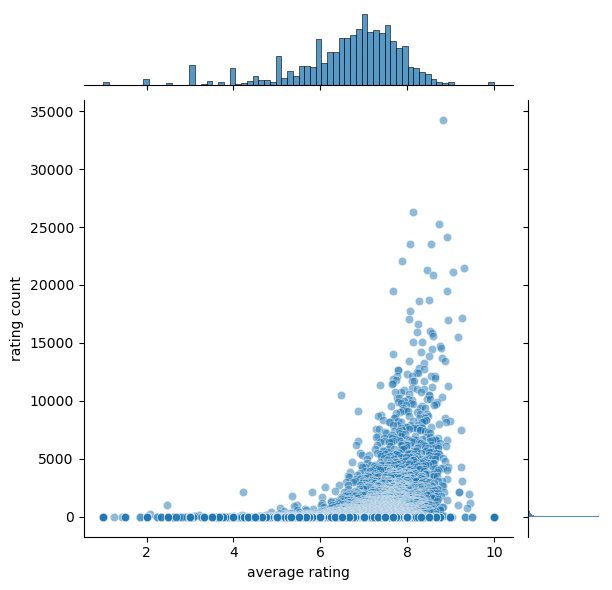

In [43]:
# plots the average rating and rating count
plot=sns.jointplot(x='average rating',y='rating count',data=ratings_count_avg,alpha=0.5, color='tab:blue')

### Scatter plot showing the average rating for each anime id

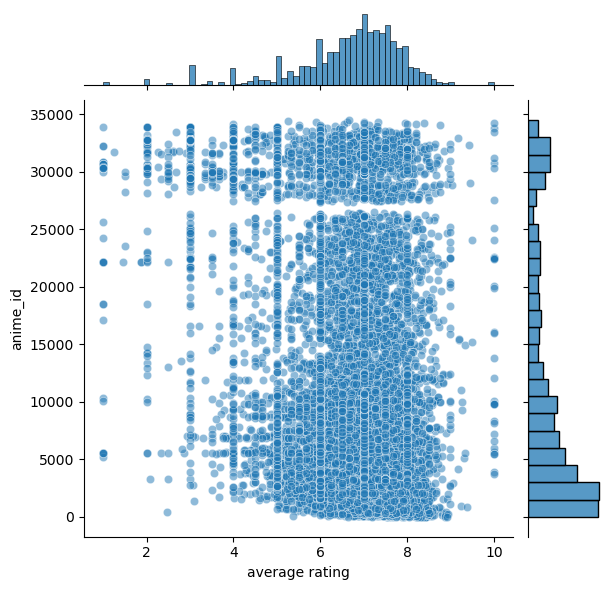

In [44]:
# shows histogram of rating by anime id
plot=sns.jointplot(x='average rating',y='anime_id',data=ratings_count_avg_id,alpha=0.5, color='tab:blue')

### Table with sorted anime by highest rating counts then average ratings 

In [45]:
# sorts anime by highest count then average rating
ratings_count_avg.sort_values(by=['rating count','average rating'], ascending=False)[:10]

,name,rating count,average rating
0,Death Note,34218,8.834502
1,Sword Art Online,26306,8.140158
2,Shingeki no Kyojin,25289,8.725731
3,Code Geass: Hangyaku no Lelouch,24124,8.927873
4,Angel Beats!,23558,8.549919
5,Elfen Lied,23523,8.064447
6,Naruto,22063,7.893985
7,Fullmetal Alchemist: Brotherhood,21493,9.322710
8,Fullmetal Alchemist,21330,8.453493
9,Code Geass: Hangyaku no Lelouch R2,21118,9.059855


In [46]:
average_ratings_genre.sort_values(by=['average rating'], ascending=False)[:10]

,genre,average rating
0,"Adventure, Shoujo, Slice of Life",10.000000
2,"Kids, Mystery, Slice of Life",10.000000
3,"Action, Historical, Kids",10.000000
4,"Action, Cars, Comedy, School, Seinen",10.000000
1,"Comedy, Drama, Historical",10.000000
5,"Adventure, Drama, Kids, Slice of Life",9.333333
6,"Action, Adventure, Drama, Fantasy, Magic, Mili...",9.322710
7,"Drama, Fantasy, Romance, Slice of Life, Supern...",9.165184
8,"Action, Comedy, Historical, Parody, Samurai, S...",9.138452
9,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",9.059855


# Testing Accuracy

In [47]:
print(test_data)

         user_id  anime_id  rating
5656992    53103      6707     7.0
3552500    32884       339     8.0
2636208    24907     23755     9.0
5554182    52213     10156     7.0
95779        994      1562    10.0
...          ...       ...     ...
3388437    31200       202     7.0
976745      9032     25157     8.0
7305031    68072      5168    10.0
1773690    17174       113     9.0
699891      6589     18153     7.0

[1000 rows x 3 columns]


In [48]:
# get all anime with a rating of 10 from the test data
test_data = test_data[test_data['rating'] == 10.0]

# keeps only one anime rated 10 for each user
test_data = test_data.drop_duplicates(subset = ["user_id"])

# empty array list to store mean values for each recommended set of anime for each user
mean_vals = []

print('determining accuracy...working with large data, please give algorithm 10 minutes to run...')
# Determines accuracy based on test users
for index, row in test_data.iterrows():  # iterates through each user in test data
    test_user_id = row['user_id']  # user ID of user
    test_anime_id = row['anime_id']  # anime ID of user's "favorite" anime that they rated 10
    test_anime_name = anime.loc[anime['anime_id'] == test_anime_id, 'name'].item()  # name of user's "favorite" anime for test
    # gets anime recommendations from passing find fimilar anime function the user's "favorite" anime
    recommendations_list = find_similar_anime(test_anime_name, test=True)  
    for rec in recommendations_list:  # iterates through anime recommendations for that user
        # assigns rating value that the user rated each recommendation
        test_rating = full_data[(full_data['name']==rec) & (full_data['user_id'] == test_user_id)]['rating']
        if test_rating.size > 0:  # if the rating has given the recommendation a rating
            test_rating = test_rating.values.item()
            test_rating_list = []  # creates empty list for each recommendation anime rating
            test_rating_list.append(test_rating)  # adds the rating for the recommended anime to the list
    mean_rating = np.mean(test_rating_list)  # finds mean of all ratings the user has given recommended anime
    mean_vals.append(mean_rating)  # adds the mean value to list for accuracy calculation
accuracy_rating = np.mean(mean_vals)  # finds the mean value of all the average ratings users have given their recommendations
print('Mean accuracy rating out of 10: ', accuracy_rating)    

determining accuracy...working with large data, please give algorithm 10 minutes to run...
Mean accuracy rating out of 10:  9.32638888888889
